In [269]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [270]:
# Import data dari Folder
dat = pd.read_csv('../data/Raw/data.csv')

In [271]:
# Mengkategorikan feature per ciri-cirinya
song_info_features = ['name', 'artists', 'id', 'release_date', 'year', 'popularity']
song_features_normalized = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness']
song_features_not_normalized = ['duration_ms', 'key', 'loudness', 'mode', 'tempo']

# Recommendation System

In [272]:
# Menghapus data sebelum 2018
dat = dat.drop(dat[(dat['year'] < 2018)].index)

In [273]:
# Pembuatan Sistem Rekomendasi Lagu

# Mendefinisikan feature yang dipakai untuk dibandingkan
features = song_features_normalized + song_features_not_normalized + ['popularity']

# Membuat dataframe baru, Menstandardisasi feature yang ada
scaler = StandardScaler()
feature_for_recommendation = scaler.fit_transform(dat[features])

# Menduplikat data yang ada ke dalam dataframe baru
dat_recommendation = dat.copy()
dat_recommendation[features] = feature_for_recommendation

# Menjadikan kapital untuk seluruh judul
dat_recommendation['name'] = dat_recommendation['name'].str.upper()

# Save dataframe baru
dat_recommendation.to_csv('dat_for_recommender.csv', index=False)

In [313]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Fungsi untuk mendapatkan nilai feature vector dari lagu yang diberikan
def get_feature_vector(song_name, year):
# def get_feature_vector(song_name, artist):
    dat_song = dat_recommendation.query('name == @song_name & year == @year')
    # dat_song = dat_recommendation.query('name == @song_name & artists == @artist')
    song_repeated = 0
    if dat_song.shape[0] == 0:
        raise Exception('The song does not exist in the dataset! \n Use search function first if you are not sure')
    if dat_song.shape[0] > 1:
        song_repeated = dat_song.shape[0]
        print(f'Warning: Multiple ({song_repeated}) songs with the same name and artist, the first one is selected!')
        dat_song = dat_song.head(1)
    feature_vector = dat_song[features].values
    return feature_vector, song_repeated

names = []

# Fungsi untuk mendapatkan lagunya mirip
def get_similar_songs(song_name, year, top_n=10, plot_type='wordcloud'):
    feature_vector, song_repeated = get_feature_vector(song_name, year)

    # menghitung nilai cosime similarity
    similarities = cosine_similarity(dat_recommendation[features].values, feature_vector).flatten()

    # Mendapatkan index dari top_n lagu yang mirip
    if song_repeated == 0:
        related_song_indices = similarities.argsort()[-(top_n+1):][::-1][1:]
    else:
        related_song_indices = similarities.argsort()[-(top_n+1+song_repeated):][::-1][1+song_repeated:]
            
    # Mengambil judul lagu, nama artis dan lagu dari lagu yang paling mirip
    similar_songs = dat_recommendation.iloc[related_song_indices][['name', 'artists', 'year']]
    
    names.append(song_name)
    names.extend(similar_songs['name'].head().tolist())
    
    if plot_type == 'wordcloud':
        # make a word cloud of the most similar songs and year, use the simalirity score as the size of the words
        similar_songs['name+year'] = similar_songs['name'] + ' (' + similar_songs['year'].astype(str) + ')'
        # create a dictionary of song and their similarity
        song_similarity = dict(zip(similar_songs['name+year'], similarities[related_song_indices]))
        # sort the dictionary by value
        song_similarity = sorted(song_similarity.items(), key=lambda x: x[1], reverse=True)
        # # create a mask for the word cloud
        # mask = np.array(Image.open("spotify-logo.png"))
        # create a word cloud
        wordcloud = WordCloud(width=1600, height=800, max_words=50, 
                            background_color='white', colormap='Set2').generate_from_frequencies(dict(song_similarity))
        plt.figure(figsize=(12,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{top_n} most similar songs to: {song_name} ({year})', fontsize=20)
        plt.tight_layout(pad=0)
        plt.show()
    
    elif plot_type == 'bar':
        # plot the text of the most similar songs and year in order, like a stacked bar chart
        similar_songs['name+year'] = similar_songs['name'] + ' (' + similar_songs['year'].astype(str) + ')'
        # create a dictionary of song and their similarity
        song_similarity = dict(zip(similar_songs['name+year'], similarities[related_song_indices]))
        # sort the dictionary by value
        song_similarity = sorted(song_similarity.items(), key=lambda x: x[1], reverse=True)
        # plot the text of the most similar songs and year in order, like a stacked bar chart
        plt.figure(figsize=(12,10))
        plt.barh(range(len(song_similarity)), [val[1] for val in song_similarity], 
                 align='center', color=sns.color_palette('pastel', len(song_similarity)))
        plt.yticks(range(len(song_similarity)), [val[0] for val in song_similarity])
        plt.gca().invert_yaxis()
        plt.title(f'{top_n} most similar songs to: {song_name} ({year})', fontsize=20)
        min_similarity = min(similarities[related_song_indices])
        max_similarity = max(similarities[related_song_indices])
        # add song name on the top of each bar
        for i, v in enumerate([val[0] for val in song_similarity]):
            plt.text(min_similarity*0.955, i, v, color='black', fontsize=12)
        # plt.xlabel('Similarity', fontsize=15)
        # plt.ylabel('Song', fontsize=15)
        plt.xlim(min_similarity*0.95, max_similarity)
        # not show figure frame and ticks
        plt.box(False)
        plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False)
        
        plt.show()
    # return similar_songs


# Membuat fungsi pencarian lagu dan mengembalikan informasi mengenainya
def search_song(song_name):
    dat_song = dat.query('name == @song_name')
    if dat_song.shape[0] == 0:
        raise Exception('The song does not exist in the dataset!')
    print(f"Great! This song is in the dataset: {dat_song[['name', 'artists', 'release_date']].to_numpy()}")
    # return dat_song[['name', 'artists', 'year', 'release_date']]

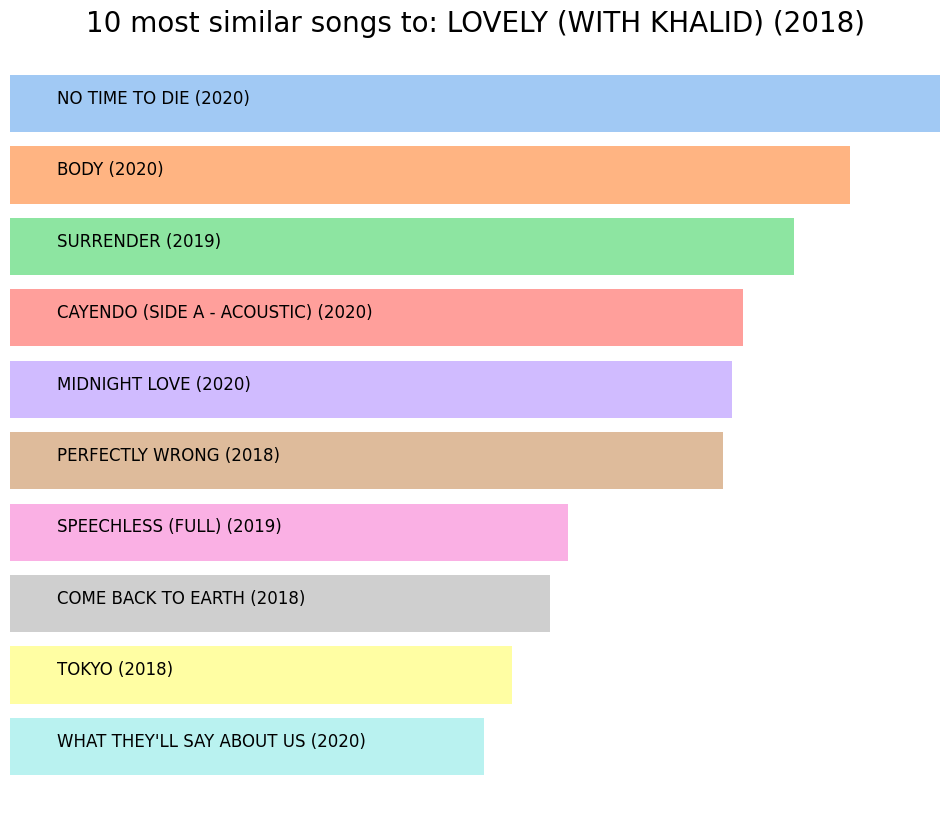

In [314]:
#Contoh Bar plot
get_similar_songs('LOVELY (WITH KHALID)', 2018, top_n=10, plot_type='bar')


In [317]:
names

[]

In [268]:
# Membuat Radar Chart
fig = go.Figure()
angles = list(dat[song_features_normalized].columns)
angles.append(angles[0])
layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

names = [element.upper() for element in names]
dat['name'] = dat['name'].str.upper()



for i in range(len(names)):
    subset = dat[dat['name'] == names[i]]
    data = [np.mean(subset[col]) for col in subset[song_features_normalized].columns]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name=names[i]))

        
fig.update_layout(
        polar=layoutdict,
        showlegend=True,template='plotly_dark'
        )
fig.show()